---
title: "Random Forests and Boosting for ARCH-like volatility forecasts"
author: "Sarem"
date: "2022-10-07"
categories: [Time Series, Decision Trees]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "Tree models are not just useful for point and mean forecasts."
---

## Introduction

In [the last article](https://www.sarem-seitz.com/forecasting-with-decision-trees-and-random-forests/), we discussed how Decision Trees and Random Forests can be used for forecasting. While mean and point forecasts are the most obvious applications, they might not always be the most useful ones.

Consider the classic example of financial returns, where the conditional mean is hard, if not impossible, to predict. Conditional variance on the other hand has been shown to exert some auto-regressive properties that can be modelled. In fact there exist countless models from the [(G)ARCH-family](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity?ref=sarem-seitz.com) that enjoy widespread popularity.

Most GARCH models make primarily linear assumptions about the auto-regressive patterns. This begs the question if we can introduce non-linear relationships for more flexibility. Given the promising performance of tree models for mean forecasts, the roadmap is clear. Can we build respective models for variance forecasts?

## Conditional variance and modelling options
Although there exists a lot of information on conditional variance models on the internet, let us quickly walk through the basics. For more insights, feel free to study the references in the [GARCH wikipedia article](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity?ref=sarem-seitz.com). Alternatively, you might also get some additional insights from these two articles [here](https://www.sarem-seitz.com/multivariate-garch-with-python-and-tensorflow/) and [here](https://www.sarem-seitz.com/lets-make-garch-more-flexible-with-normalizing-flows/).

To get started, we state our forecast target:
$$
\operatorname{Var}\left(Y_t \mid y_{t-1}, \ldots, y_{t-k}\right)
$$
Pretty simple - we want to predict variance of a time-series based on the series' past realizations. There is only one problem: **We do not observe the time-series' variance**.

Of course, this is also true when for the time-series' mean. However, by minimizing the mean-squared-error, [our model will generate predictions for the mean](https://math.stackexchange.com/questions/2554243/understanding-the-mean-minimizes-the-mean-squared-error?ref=sarem-seitz.com) (a.k.a. expected value). In a time-series modelling problem, this looks as follows:
$$
\hat{f}^*=\underset{\hat{f} \in \mathcal{M}}{\operatorname{argmin}} \mathbb{E}\left[\left(\hat{f}\left(y_{t-1}, \ldots, y_{t-k}\right)-y_t\right)^2\right]
$$
$\mathcal{M}$ the set of all admissible models
$$
\Rightarrow \hat{f}^*\left(y_{t-1}, \ldots, y_{t-k}\right) \approx \mathbb{E}\left[Y_t \mid y_{t-1}, \ldots, y_{t-k}\right]
$$
In words: A model that minimizes the MSE of the conditionals can be used as an estimator for the conditional mean. Of course, this requires the set of admissible models to be large enough. A linear model, for example, will fail as an approximation for a highly non-linear conditional mean.

Luckily, Decision Tree ensembles are very flexible and thus should make a decent set of candidate models.

Now hopes are up that there exists a suitable loss function that will find a similar estimator for conditional variances. Indeed there is a very convenient way:

### Estimating Variance directly
This approach requires only a tiny bit of probability theory and a loose assumption on our data. Recall that the variance of any random variable can be decomposed as follows:
$$
\operatorname{Var}\left(Y_t \mid y_{t-1}, \ldots, y_{t-k}\right)=E\left[Y_t^2 \mid y_{t-1}, \ldots, y_{t-k}\right]-E\left[Y_t \mid y_{t-1}, \ldots, y_{t-k}\right]^2
$$
Notice that the expectation on the right can be estimated via the MSE minimization from before. Thus, with a respective estimator (e.g. Decision Tree ensemble), we can make use of the next formula:
$$
\begin{gathered}
\tilde{Y}_t\left|y_{t-1}, \ldots, y_{t-k}=Y_t\right| y_{t-1}, \ldots, y_{t-k}-\mathbb{E}\left[Y_t \mid y_{t-1}, \ldots, y_{t-k}\right] \\
\Rightarrow \mathbb{E}\left[\tilde{Y}_t \mid y_{t-1}, \ldots, y_{t-k}\right]=0, \\
\Rightarrow \operatorname{Var}\left(\tilde{Y}_t \mid y_{t-1}, \ldots, y_{t-k}\right)=\operatorname{Var}\left(Y_t \mid y_{t-1}, \ldots, y_{t-k}\right)
\end{gathered}
$$
Obviously, we don't observe the actual conditional mean but only have our tree-based estimator at hand. Therefore:
$$
\begin{gathered}
\tilde{Y}_t\left|y_{t-1}, \ldots, y_{t-k}=Y_t\right| y_{t-1}, \ldots, y_{t-k}-\hat{f}^*\left(y_{t-1}, \ldots, y_{t-k}\right) \\
\Rightarrow \mathbb{E}\left[\tilde{Y}_t \mid y_{t-1}, \ldots, y_{t-k}\right] \approx 0, \\
\Rightarrow \operatorname{Var}\left(\tilde{Y}_t \mid y_{t-1}, \ldots, y_{t-k}\right) \approx \operatorname{Var}\left(Y_t \mid y_{t-1}, \ldots, y_{t-k}\right)
\end{gathered}
$$
Plugging this back into the variance formula, we get:
$$
\begin{array}{r}
\operatorname{Var}\left(\tilde{Y}_t \mid y_{t-1}, \ldots, y_{t-k}\right)=E\left[\tilde{Y}_t^2 \mid y_{t-1}, \ldots, y_{t-k}\right]-E\left[\tilde{Y}_t \mid y_{t-1}, \ldots, y_{t-k}\right]^2 \\
=E\left[\tilde{Y}_t^2 \mid y_{t-1}, \ldots, y_{t-k}\right]-0^2 \\
\Rightarrow \operatorname{Var}\left(\tilde{Y}_t \mid y_{t-1}, \ldots, y_{t-k}\right)=\operatorname{Var}\left(Y_t \mid y_{t-1}, \ldots, y_{t-k}\right) \\
=E\left[\tilde{Y}_t^2 \mid y_{t-1}, \ldots, y_{t-k}\right]
\end{array}
$$

This implies that the **variance of our target variable** equals the **expectation of the squared mean-transformed variable**.

Notice that we conditioned the transformed variable on the lagged original time-series. We can equally condition the transformed variable on the **lagged transformed** time-series. The latter is obviously much more convenient and popular. Thus, we'll use this approach from now on.

Going back to our first equation, we can now easily build an estimator for this mean:
$$
\begin{gathered}
\hat{f}^{* *}=\underset{\hat{f} \in \mathcal{M}}{\operatorname{argmin}} \mathbb{E}\left[\left(\hat{f}\left(\tilde{y}_{t-1}, \ldots, \tilde{y}_{t-k}\right)-\tilde{y}_t^2\right)^2\right] \\
\Rightarrow \hat{f}^{* *}\left(\tilde{y}_{t-1}, \ldots, \tilde{y}_{t-k}\right) \approx \mathbb{E}\left[\tilde{Y}_t^2 \mid \tilde{y}_{t-1}, \ldots, \tilde{y}_{t-k}\right] \\
\quad\left(=\operatorname{Var}\left(Y_t \mid y_{t-1}, \ldots, y_{t-k}\right)\right)
\end{gathered}
$$
We can now conclude the following:

> If we train another model to **minimize MSE** on the **squared transformed variable**, that model becomes an estimator for the conditional **variance**.

Obviously, this method has one caveat: **The model must only produce non-negative predictions**. Otherwise, there is no guarantee that we won't receive negative variance predictions on a test set.

This is where Decision Trees and Random Forests come in handy. The squared data for training is **always non-negative**. Therefore, a trained Decision Tree will only produce non-negative predictions, too.

A raw linear regression model on the other hand would not have such guarantees. Unfortunately, this also excludes Gradient Boosted Trees from the range of possible models. Standard Boosting produces a weighted sum of Decision Trees. Consequently, **a single negative weight could result in negative predictions**.

There is, nevertheless, a way to make Gradient Boosting work as well:

### Using an adjusted loss function
Since Gradient Boosting is so powerful, it would be a bummer to not be able to use it for our problem. Luckily, most popular Boosting libraries allow to define custom loss functions. This is exactly what we will do here.

Consider again the mean-subtracted variable:
$$
\mathbb{E}\left[\tilde{Y}_t \mid \tilde{y}_{t-1}, \ldots, \tilde{y}_{t-k}\right] \approx 0
$$
As a result we can impose the following distributional assumption:
$$
\tilde{Y}_t \mid \tilde{y}_{t-1}, \ldots, \tilde{y}_{t-k} \sim \mathcal{N}\left(0, \exp \left(\hat{f}\left(\tilde{y}_{t-1}, \ldots, \tilde{y}_{t-k}\right)\right)\right)
$$
The output from a Gradient Boosting algorithm itself can be negative. Adding exponentiation ensures non-negative variance. Now we simply need to translate the above into a log-likelihood loss function and calculate gradient and hessian. Then we plug everything into a Boosting algorithm:
$$
\begin{gathered}
L\left(\hat{f}_t, \tilde{y}_t\right) \\
=-0.5 \log (2 \pi)-0.5 \log \left(\exp \left(\hat{f}_t\right)\right)-\frac{\tilde{y}_t{ }^2}{2 \exp \left(\hat{f}_t\right)} \\
\text { where } \hat{f}_t=\hat{f}\left(y_{t-1}, \ldots, y_{t-k}\right) \\
\Rightarrow \frac{\partial L\left(\hat{f}_t, \tilde{y}_t\right)}{\partial \hat{f}_t}=-0.5+\frac{\tilde{y}_t{ }^2}{2 \exp (\hat{f})} \\
\Rightarrow \frac{\partial^2 L\left(\hat{f}_t, \tilde{y}_t\right)}{\partial^2 \hat{f}_t}=-\frac{\tilde{y}_t^2}{2 \exp (\hat{f})}
\end{gathered}
$$
Keep in mind that we need to apply the chain-rule to our additional exponential transformation.For [Microsoft's LightGBM package](https://github.com/microsoft/LightGBM?ref=sarem-seitz.com), our custom loss would now look as follows:

In [1]:
#see e.g. https://hippocampus-garden.com/lgbm_custom/

def gaussian_loss(y_pred, data):
    y_true = data.get_label()
    
    loglikelihood = -0.5*np.log(2*np.pi) - 0.5*y_pred - 0.5/np.exp(y_pred)*y_true**2
    #remember that boosting minimizes the loss function but we want to maximize the loglikelihood
    #thus, need to return the negative loglikelihood to the Boosting algorithm
    #also applies to gradient and hessian below
    
    return "loglike", -loglikelihood, False

def gaussian_loss_gradhess(y_pred, data):
    y_true = data.get_label()
    
    exp_pred = np.exp(y_pred)
    
    #pay attention to the chain rule as we exp() the Boosting output before plugging it into the loglikelihood
    grad = -0.5 + 0.5/exp_pred*y_true**2 
    hess = -0.5/exp_pred*y_true**2

    return -grad, -hess

Now, let us implement both approaches and compare them against benchmark models:

## Tree ensembles for volatility forecasts in Python
In general, the implementation should be straightforward. Apart from avoiding careless mistakes, there is nothing too special that be need to be aware of.

As a dataset, we'll use five years of standardized Dow Jones log-returns:

[*********************100%***********************]  1 of 1 completed


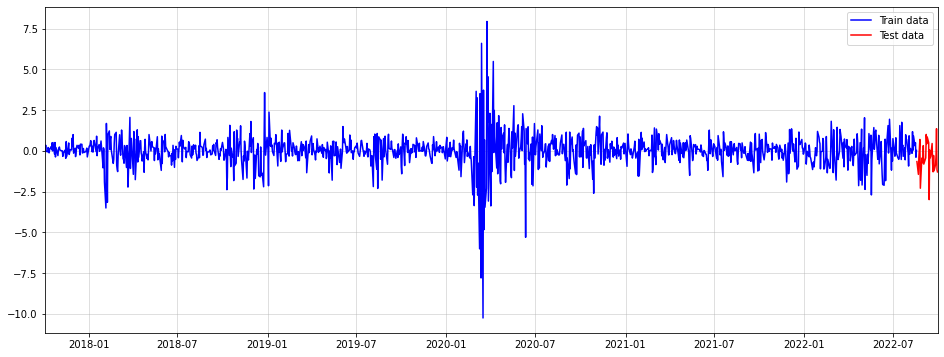

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

symbol = "^DJI"

data = yf.download(symbol, start="2017-10-01", end="2022-10-01")
returns = np.log(data["Close"]).diff().dropna()

n_test = 30

train = returns.iloc[:-n_test]

train_mean = train.mean()
train_std = train.std()

train = (train-train_mean)/train_std

test = returns.iloc[-n_test:]
test = (test-train_mean)/train_std #be careful to spill information over into the test period

plt.figure(figsize = (16,6))
plt.plot(train, color = "blue", label = "Train data")
plt.plot(test, color = "red", label = "Test data")
plt.grid(alpha = 0.5)
plt.margins(x=0)
plt.legend()

Notice that we are performing a z-Normalization. This will make the subsequent GARCH model more robust to degenerate scaling of the time-series. Also, we reserve the last 30 days of data for a test set. Be careful not to introduce lookahead bias here.

Finally, it is reasonable to presume that conditional expected returns are always zero, i.e.
$$
\mathbb{E}\left[Y_t \mid y_{t-1}, \ldots, y_{t-k}\right]=0
$$
Otherwise, somebody else would have likely discovered this anomaly before us and arbitraged it away. Therefore, we don't need to apply the mean-subtraction in the first place. Rather, we'll directly use raw log-returns for our variance estimation.

### Random Forest volatility forecasts

For the Random Forest model, we use `[sklearn's](https://scikit-learn.org/stable/?ref=sarem-seitz.com) RandomForestRegressor`.  To limit the risk of overfitting, we run the algorithm with a `max_depth=3`. Given the typically noisy behaviour of financial time-series, such regularization seems reasonable.

Finally, we set `k=5` which lets our algorithm consider the past five observations for forecasting. While we could set this lower or higher, there is a tradeoff between omitting information and overfitting. In production, you would obviously do more backtesting to find the optimal number of lags.

In code, we now have

In [3]:
from sklearn.ensemble import RandomForestRegressor

n_lags = 5

train_lagged = pd.concat([train**2]+[train.shift(i) for i in range(1,n_lags+1)],1).dropna()

y_train = train_lagged.iloc[:,0]
X_train = train_lagged.iloc[:,1:]


forest_model = RandomForestRegressor(max_depth=3, n_estimators=100, n_jobs=-1, random_state=123)
forest_model.fit(X_train.values, y_train.values)

/var/folders/2d/hl2cr85d2pb2kfbmsng3267c0000gn/T/ipykernel_70730/2717592527.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  train_lagged = pd.concat([train**2]+[train.shift(i) for i in range(1,n_lags+1)],1).dropna()


RandomForestRegressor(max_depth=3, n_jobs=-1, random_state=123)

To generate forecasts, we apply Monte-Carlo sampling. Then, we use those samples to estimate the 90% forecast interval. This is necessary because our model can only predict conditional variance one step ahead. Presuming Gaussian noise, this looks as follows:

In [4]:
from scipy.stats import norm

samp_size = 50000

Xt = pd.DataFrame(pd.concat([train.shift(i) for i in range(n_lags)],1).dropna().iloc[-1,:].values.reshape(1,-1))
Xt = pd.concat([Xt for _ in range(samp_size)])
Xt.columns = X_train.columns

np.random.seed(123)

forest_samples = []


for t in range(len(test)):
    pred = forest_model.predict(Xt.values).reshape(-1,1)
    samp = norm(0, 1).rvs(samp_size).reshape(-1,1)*np.sqrt(pred)
    forest_samples.append(samp)

    Xt = pd.DataFrame(np.concatenate([np.array(samp).reshape(-1,1),Xt.values[:,:-1]],1))
    Xt.columns = X_train.columns
    
    
forest_samples_matrix = np.concatenate(forest_samples,1)

forest_std = np.std(forest_samples_matrix,0)
forest_lower = np.quantile(forest_samples_matrix,0.05,0)
forest_upper = np.quantile(forest_samples_matrix,0.95,0)

/var/folders/2d/hl2cr85d2pb2kfbmsng3267c0000gn/T/ipykernel_70730/1944271020.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  Xt = pd.DataFrame(pd.concat([train.shift(i) for i in range(n_lags)],1).dropna().iloc[-1,:].values.reshape(1,-1))


50000 samples per timestamp should suffice for now. If you need more accuracy, feel free to increase this amount by a lot.

### Gradient Boosting volatility forecasts
The Gradient Boosting variant is quite similar to the Random Forest approach. We only need to take care of the LightGBM-specifics for data preprocessing. Also keep in mind that our target now needs to be the raw, z-normalized time-series, not the squared one.

In [5]:
import lightgbm as lgb

train_lagged = pd.concat([train]+[train.shift(i) for i in range(1,n_lags+1)],1).dropna()

y_train = train_lagged.iloc[:,0]
X_train = train_lagged.iloc[:,1:]

train_data = lgb.Dataset(X_train.values, label=y_train.values)
param = {"num_leaves":2, "learning_rate":0.1, "seed": 123}

num_round = 1000
boosted_model = lgb.train(param, train_data, num_round, fobj=gaussian_loss_gradhess, feval=gaussian_loss)

np.random.seed(123)

boosted_samples = []

for t in range(len(test)):
    pred = boosted_model.predict(Xt.values).reshape(-1,1)
    samp = norm(0, 1).rvs(samp_size).reshape(-1,1)*np.sqrt(np.exp(pred))
    boosted_samples.append(samp)

    Xt = pd.DataFrame(np.concatenate([np.array(samp).reshape(-1,1),Xt.values[:,:-1]],1))
    Xt.columns = X_train.columns
    
    
boosted_samples_matrix = np.concatenate(boosted_samples,1)

boosted_std = np.std(boosted_samples_matrix,0)
boosted_lower = np.quantile(boosted_samples_matrix,0.05,0)
boosted_upper = np.quantile(boosted_samples_matrix,0.95,0)

/var/folders/2d/hl2cr85d2pb2kfbmsng3267c0000gn/T/ipykernel_70730/729234487.py:3: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  train_lagged = pd.concat([train]+[train.shift(i) for i in range(1,n_lags+1)],1).dropna()


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1223, number of used features: 5
[LightGBM] [Warning] Using self-defined objective function


To check if our models are actually any good, let us compare them against two benchmarks:

### GARCH and kernel density benchmarks and evaluation

Since we want to improve conditional volatility forecasts, GARCH seems to be the most obvious comparison. To match the number of lags in our tree ensembles, we'll use a GARCH(5,5) model.

As a second benchmark, let us use a simple i.i.d. kernel density fit. I.e. we presume that each future observation is drawn independently from the same density as the training data:

In [6]:
from arch import arch_model
from scipy.stats import gaussian_kde


am = arch_model(train, p=n_lags,q=n_lags)
res = am.fit(update_freq=5)
forecasts = res.forecast(horizon=len(test), reindex=False).variance.values[0,:]

garch_samples_matrix = res.forecast(horizon=len(test), simulations = 50000, reindex=False, method = "simulation").simulations.values[0,:,:]

garch_std = np.std(garch_samples_matrix,0)
garch_lower = np.quantile(garch_samples_matrix,0.05,0)
garch_upper = np.quantile(garch_samples_matrix,0.95,0)

iid_kde = gaussian_kde(train)
iid_kde_samp = iid_kde.resample((50000*len(test))).reshape(50000,len(test))

kde_lower = np.quantile(iid_kde_samp,0.05,0)
kde_upper = np.quantile(iid_kde_samp,0.95,0)

Iteration:      5,   Func. Count:     75,   Neg. LLF: 1688.2522911700148
Iteration:     10,   Func. Count:    145,   Neg. LLF: 1524.6402966915884
Iteration:     15,   Func. Count:    216,   Neg. LLF: 1306.756160681614
Iteration:     20,   Func. Count:    281,   Neg. LLF: 1306.5361795921172
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1306.5361512322356
            Iterations: 23
            Function evaluations: 320
            Gradient evaluations: 23


At last, the actual evaluation. As a performance measure, we want to use the out-of-sample log-likelihood - the higher the better. That way we will see which forecasted probability density performs best on our test set.

Since we could only sample from the forecast distributions, we'll fit a kernel density to each of the Monte-Carlo samples. For our benchmark, we obviously have the kernel density fit from the training data already.

Finally, we calculate the log-likelihood for the kernel densities as a proxy:

Text(0.5, 1.0, 'I.i.d. KDE - Test set loglikelihood: -46.681')

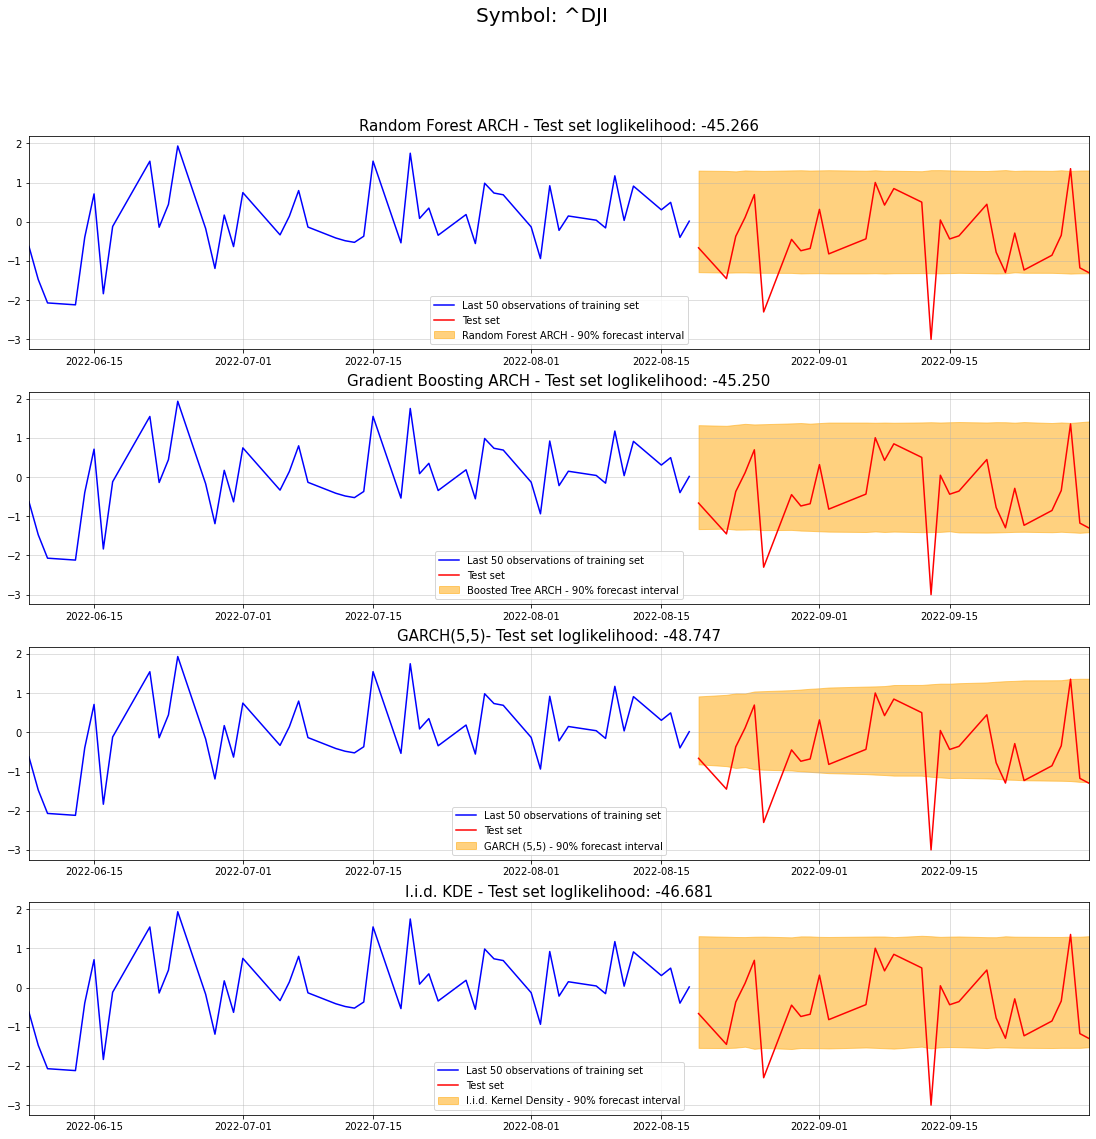

In [7]:
benchmark_lpdfs = [iid_kde.logpdf(test[i])[0] for i in range(len(test))]
garch_lpdfs = [gaussian_kde(garch_samples_matrix[:,i]).logpdf(test[i])[0] for i in range(len(test))]
forest_lpdfs = [gaussian_kde(forest_samples_matrix[:,i]).logpdf(test[i])[0] for i in range(len(test))]
boosted_lpdfs = [gaussian_kde(boosted_samples_matrix[:,i]).logpdf(test[i])[0] for i in range(len(test))]


fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(19,18))
st = fig.suptitle("Symbol: "+symbol, fontsize=20)


ax1.plot(train.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
ax1.plot(test, color = "red", label = "Test set")
ax1.grid(alpha = 0.5)
ax1.margins(x=0)
ax1.fill_between(test.index, forest_lower, forest_upper, color="orange", alpha=0.5, label="Random Forest ARCH - 90% forecast interval")
ax1.legend()
ax1.set_title("Random Forest ARCH - Test set loglikelihood: {}".format(str(np.sum(forest_lpdfs))[:7]), fontdict={'fontsize': 15})


ax2.plot(train.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
ax2.plot(test, color = "red", label = "Test set")
ax2.grid(alpha = 0.5)
ax2.margins(x=0)
ax2.fill_between(test.index, boosted_lower, boosted_upper, color="orange", alpha=0.5, label="Boosted Tree ARCH - 90% forecast interval")
ax2.legend()
ax2.set_title("Gradient Boosting ARCH - Test set loglikelihood: {}".format(str(np.sum(boosted_lpdfs))[:7]), fontdict={'fontsize': 15})


ax3.plot(train.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
ax3.plot(test, color = "red", label = "Test set")
ax3.grid(alpha = 0.5)
ax3.margins(x=0)
ax3.fill_between(test.index, garch_lower, garch_upper, color="orange", alpha=0.5, label="GARCH (5,5) - 90% forecast interval")
ax3.legend()
ax3.set_title("GARCH(5,5)- Test set loglikelihood: {}".format(str(np.sum(garch_lpdfs))[:7]), fontdict={'fontsize': 15})


ax4.plot(train.iloc[-50:], color = "blue", label = "Last 50 observations of training set")
ax4.plot(test, color = "red", label = "Test set")
ax4.grid(alpha = 0.5)
ax4.margins(x=0)
ax4.fill_between(test.index, kde_lower, kde_upper, color="orange", alpha=0.5, label="I.i.d. Kernel Density - 90% forecast interval")
ax4.legend()
ax4.set_title("I.i.d. KDE - Test set loglikelihood: {}".format(str(np.sum(benchmark_lpdfs))[:7]), fontdict={'fontsize': 15})

In fact, our tree models perform best for our 30 day test set. Surprisingly, the GARCH model performed worse than our kernel density benchmark. Keep in mind though that a single evaluation doesn't allow any generalizing conclusions.

Nevertheless, our Random Forest and Gradient Boosting ARCH models appear to work reasonably well.

## Conclusion
This article gave a quick demonstration of how tree ensembles can be used for volatility forecasts. Although the example models could possibly be enhanced a lot, the initial ideas already seem to work quite well.

Possible enhancement could be a better choice of conditional distributions. I.e. all our models, except the kernel density benchmark, worked with Gaussianity assumptions. In for financial time-series, this might obviously be a sub-optimal choice. If, for example, we wanted to account for heavy conditional tails, a [Student's T](https://en.wikipedia.org/wiki/Student%27s_t-distribution?ref=sarem-seitz.com)-distribution would be better suited.

PS: [Notebook for this article is available on GitHub](https://github.com/SaremS/sample_notebooks/blob/master/Decision%20Tree%20Ensembles%20for%20Volatility%20Forecasts.ipynb?ref=sarem-seitz.com).

## References
**[1]** Breiman, Leo. Random forests. Machine learning, 2001, 45.1, p. 5-32.

**[2]** Bollerslev, Tim. Modelling the coherence in short-run nominal exchange rates: a multivariate generalized ARCH model. The review of economics and statistics, 1990, p. 498-505.

**[3]** Ke, Guolin, et al. Lightgbm: A highly efficient gradient boosting decision tree. Advances in neural information processing systems, 2017, 30